In [1]:
%matplotlib inline

In [2]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Statistics

This notebook provides examples for extracting useful statistics from processed hdf5 data.

In [3]:
from e11 import H5Data
from e11.stats import statistics
from e11.tools import add_level
from e11.process import vrange

In [4]:
# read file
fil = os.path.join(os.getcwd(), 'example_data', 'array_data.h5')
data = H5Data(fil)

In [5]:
data.log

100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1201.75it/s]


,ACQUIRE,DATETIME,END,ERROR,LOOP,OVERRIDE,START,VAR:PAUSE,ELAPSED
squid,,,,,,,,,
1,10.036975,2017-12-01 15:41:22,3.594988e+09,0,1,0,3.594988e+09,300,00:00:00
2,10.021719,2017-12-01 15:41:33,3.594988e+09,0,1,0,3.594988e+09,600,00:00:11
3,10.034403,2017-12-01 15:41:45,3.594988e+09,0,1,0,3.594988e+09,900,00:00:23
4,10.022052,2017-12-01 15:41:55,3.594988e+09,0,2,0,3.594988e+09,300,00:00:33
5,10.027435,2017-12-01 15:42:06,3.594988e+09,0,2,0,3.594988e+09,600,00:00:44
6,10.027131,2017-12-01 15:42:18,3.594988e+09,0,2,0,3.594988e+09,900,00:00:56


First, we process array data using the `vrange()` function. This returns a `pandas.DataFrame()` of the measured vertical range for each row of the array.

In [6]:
rng = data.apply(vrange, data.squids, 'OSC_0')
rng.head()

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 158.27sq/s]


vrange
squid measurement          
1     0            1.033028
      1            1.012191
      2            1.032403
      3            1.070328
      4            1.062143

Next, we use the `statistics()` function to find the average vertical range per squid.

In [7]:
av = statistics(rng)
av.head()

vrange                              
       count       err      mean       std
squid                                     
1         25  0.003350  1.038482  0.016752
2         25  0.002847  1.039364  0.014236
3         26  0.001758  1.043457  0.008966
4         25  0.002988  1.044290  0.014941
5         25  0.003784  1.034683  0.018921

The kwarg `mode` can be used to get more or less statisical information.  For example, 

In [8]:
# mean and standard error
statistics(rng, mode='abbr').head()

vrange          
            err      mean
squid                    
1      0.003350  1.038482
2      0.002847  1.039364
3      0.001758  1.043457
4      0.002988  1.044290
5      0.003784  1.034683

In [9]:
# full statistics output
statistics(rng, mode='full').head()

vrange                                                              \
       count       err       max      mean    median       min     range   
squid                                                                      
1         25  0.003350  1.070328  1.038482  1.039619  1.000539  0.069789   
2         25  0.002847  1.064080  1.039364  1.042150  1.002382  0.061698   
3         26  0.001758  1.061674  1.043457  1.043071  1.020032  0.041642   
4         25  0.002988  1.083854  1.044290  1.042212  1.020626  0.063229   
5         25  0.003784  1.063393  1.034683  1.033215  0.997321  0.066072   

                 
            std  
squid            
1      0.016752  
2      0.014236  
3      0.008966  
4      0.014941  
5      0.018921

Finally, the `squid` value can be used to associate the statistics with VAR values.

In [10]:
# map measurements to var values
df = add_level(data.var, 'VAR').join(av)
df.head()

VAR vrange                              
      PAUSE  count       err      mean       std
squid                                           
1       300     25  0.003350  1.038482  0.016752
2       600     25  0.002847  1.039364  0.014236
3       900     26  0.001758  1.043457  0.008966
4       300     25  0.002988  1.044290  0.014941
5       600     25  0.003784  1.034683  0.018921

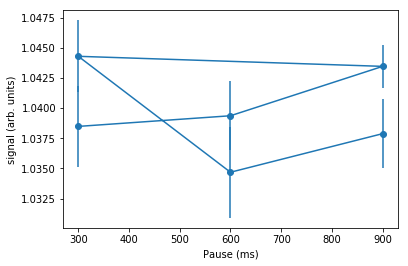

In [11]:
# plot
fig, ax = plt.subplots()

xvals = df[('VAR', 'PAUSE')]
yvals = df[('vrange', 'mean')]
yerr =  df[('vrange', 'err')]
ax.errorbar(xvals, yvals, yerr=yerr, marker='o')

#format
ax.set_xlabel('Pause (ms)')
ax.set_ylabel('signal (arb. units)')

#output
plt.show()

## Loops

Sometimes different groups might be associated with identical experimental conditions (VARS), e.g., if an experiment has been looped.

The plot above indicates that in the example there were 2 loops recorded using the same values for `VAR:PAUSE`.  The datasets can be grouped together to find the overall statistics for unique VAR values.

In [12]:
# map measurements to var values
df2 = data.var.join(rng)
df2.head()

PAUSE    vrange
squid measurement                 
1     0              300  1.033028
      1              300  1.012191
      2              300  1.032403
      3              300  1.070328
      4              300  1.062143

In [13]:
# then evaluate the statistics when grouped by var values
st = statistics(df2, groupby=data.var.columns, mode='full')
st.head()

vrange                                                              \
       count       err       max      mean    median       min     range   
PAUSE                                                                      
300       50  0.002260  1.083854  1.041386  1.040635  1.000539  0.083316   
600       50  0.002367  1.064080  1.037024  1.042134  0.997321  0.066759   
900       51  0.001702  1.069203  1.040724  1.041619  1.012878  0.056325   

                 
            std  
PAUSE            
300    0.015981  
600    0.016739  
900    0.012155

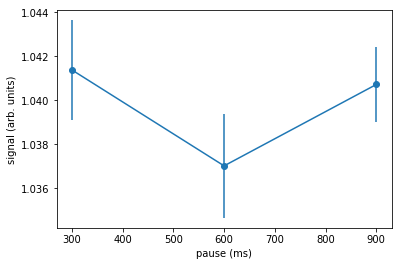

In [14]:
# plot
fig, ax = plt.subplots()

xvals = st.index.get_level_values('PAUSE')
yvals = st[('vrange', 'mean')]
yerr =  st[('vrange', 'err')]
ax.errorbar(xvals, yvals, yerr=yerr, marker='o')

#format
ax.set_xlabel('pause (ms)')
ax.set_ylabel('signal (arb. units)')

#output
plt.show()